# Common import and setup


In [1]:
import os, sys, time, pytest

import matplotlib.pyplot as plt
from matplotlib import patches, lines
import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal

import pdfminer

from IPython.display import display

# Make sure we use the local version of camelot if it is here
sys.path.insert(0, os.path.abspath(''))

import camelot
from camelot.core import Table, TableList, TextEdges
from camelot.__version__ import generate_version
from camelot.utils import get_text_objects, text_in_bbox
from camelot.parsers.stream import Stream
from camelot.parsers.lattice import Lattice
from camelot.parsers.network import Network
from camelot.parsers.hybrid import Hybrid
from camelot.handlers import PDFHandler
from camelot.plotting import draw_pdf
from tests.data import *

testdir = os.path.dirname(os.path.abspath('.'))
testdir = os.path.join(testdir, "camelot/tests/files")

# To check which library we're using
camelot.__file__


'/Users/francoishuet/Code/camelot/camelot/__init__.py'

## Selection of file to review

This is seeded with the unit test files for convenience.

In [26]:
kwargs = {}
data = None
# pdf_file, kwargs, data = "superscript.pdf", {"flag_size": True}, data_stream_flag_size # test_hybrid_flag_size
# pdf_file = "health.pdf"  # test_hybrid
# pdf_file = "clockwise_table_2.pdf"

# pdf_file = "tabula/12s0324.pdf" # interesting because contains two separate tables

# pdf_file = "clockwise_table_2.pdf"  # test_hybrid_table_rotated / test_stream_table_rotated
# pdf_file, kwargs = "tabula/us-007.pdf", {"table_regions": ["320,335,573,505"]} # test_hybrid_table_regions
# pdf_file, kwargs = "detect_vertical_false.pdf", {"strip_text": " ,\n"}  # data_stream_strip_text
# pdf_file, kwargs, data = "tabula/m27.pdf", {"columns": ["72,95,209,327,442,529,566,606,683"], "split_text": True, }, data_stream_split_text  # data_stream_split_text
# pdf_file = "vertical_header.pdf"

# pdf_file, kwargs = "vertical_header.pdf", {"pages": "2"}

# pdf_file, kwargs = "PIR_Prospetto.dOfferta.pdf", {"pages": "6"}
# pdf_file = "twotables_2.pdf" # Lattice is better
pdf_file = "camelot-issue-132-multiple-tables.pdf"
# pdf_file, kwargs, data = "edge_tol.pdf", {"edge_tol": 500}, data_stream_edge_tol
# pdf_file, kwargs, data = "edge_tol.pdf", {}, data_stream_edge_tol
# pdf_file, kwargs = "tabula/icdar2013-dataset/competition-dataset-us/us-030.pdf", {"pages": "2"}  # test_lattice
# pdf_file, kwargs = "background_lines_1.pdf", {"process_background": True}  # test_lattice_process_background

filename = os.path.join(testdir, pdf_file)

In [27]:
FLAVORS = ["stream", "lattice", "network", "hybrid"]
PLOT_HEIGHT = 12
tables_parsed = {}
parses = {}
max_tables = 0
for idx, flavor in enumerate(FLAVORS):
    timer_before_parse = time.perf_counter()
    error, tables = None, []
    try:
        tables = camelot.read_pdf(filename, flavor=flavor, debug=True, **kwargs)
    except ValueError as value_error:
        error = f"Invalid argument for parser {flavor}: {value_error}"
        print(error)
    timer_after_parse = time.perf_counter()
    max_tables = max(max_tables, len(tables))

    parses[flavor] = {
        "tables": tables,
        "time": timer_after_parse - timer_before_parse,
        "error": error
    }

    print(f"##### {flavor} ####")
    print(f"Found {len(tables)} table(s):")
    for idx, table in enumerate(tables):
        flavors_matching = []
        for previous_flavor, previous_tables in tables_parsed.items():
            for prev_idx, previous_table in enumerate(previous_tables):
                if previous_table.df.equals(table.df):
                    flavors_matching.append(
                        f"{previous_flavor} table {prev_idx}")
        print(f"## Table {idx} ##")
        if flavors_matching:
            print(f"Same as {', '.join(flavors_matching)}.")
        else:
            display(table.df)
            print("")
    tables_parsed[flavor] = tables


##### stream ####
Found 1 table(s):
## Table 0 ##


,0,1,2,3
0,1,Ghfhbdhj,1,Hgfdhgjsdhjdsf
1,Vgvhgh,Hj,Hj,Hj
2,Hj,Hj,Hj,Hj
3,Hj,Hj,J,Hj
4,V,C,D,Gfhj
5,Hjb,B,Jhbh,Hj
6,Hjdhshj,Hjhjhh,Ddnj,dsxv



##### lattice ####
Found 1 table(s):
## Table 0 ##
Same as stream table 0.
##### network ####
Found 2 table(s):
## Table 0 ##
Same as stream table 0, lattice table 0.
## Table 1 ##


,0,1,2
0,Trtrt,H,Gh
1,Gh,V,Hv
2,Hv,Bhjb,hg



##### hybrid ####
Found 2 table(s):
## Table 0 ##
Same as stream table 0, lattice table 0, network table 0.
## Table 1 ##
Same as network table 1.


## Show tables layout within original document

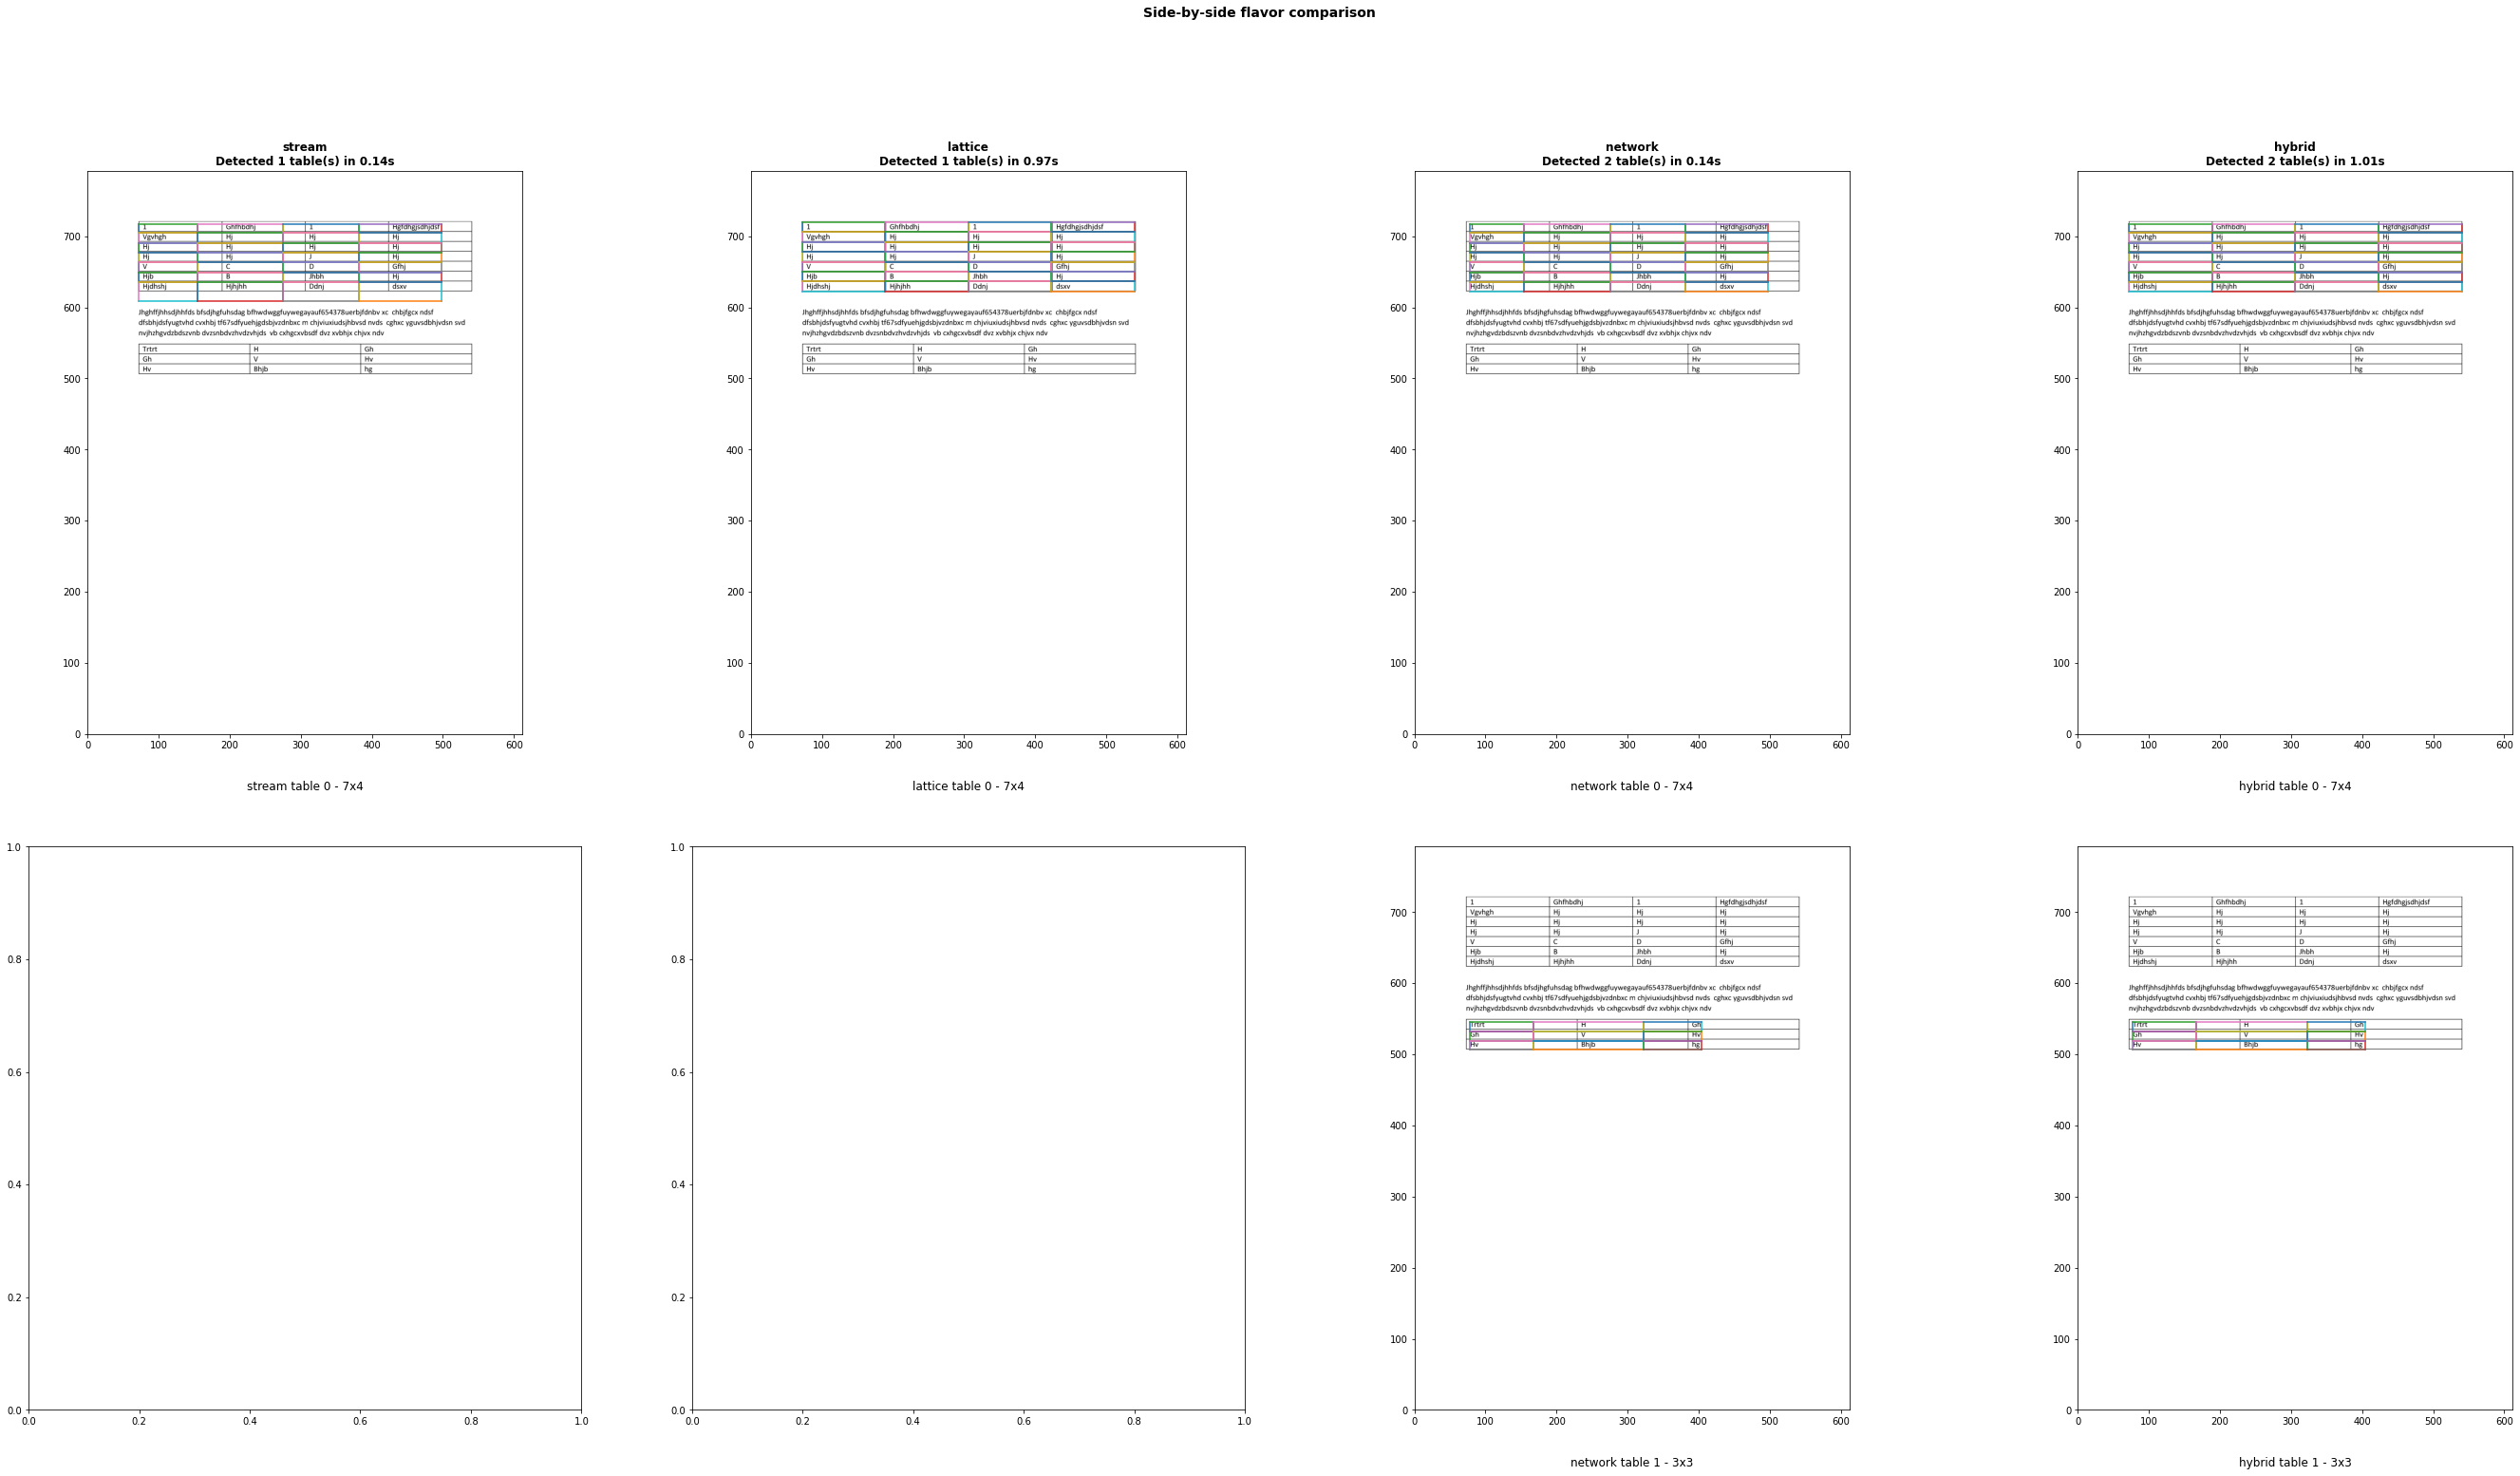

In [28]:

# Set up plots to be large enough for visualization
row_count = max(max_tables, 1)
plt.rcParams["figure.figsize"] = [PLOT_HEIGHT * len(FLAVORS), PLOT_HEIGHT * row_count]
fig, axes = plt.subplots(row_count, len(FLAVORS))
fig.suptitle('Side-by-side flavor comparison', fontsize=14, fontweight='bold')
for idx, flavor in enumerate(FLAVORS):
    parse = parses[flavor]
    tables = parse["tables"]
    top_ax = axes.flat[idx]
    title = f"{flavor}\n" \
            f"Detected {len(tables)} table(s) in {parse['time']:.2f}s"
    if parse['error']:
        title = title + f"\nError parsing: {parse['error']}"
    top_ax.set_title(title, fontsize=12, fontweight='bold')
    for table_idx, table in enumerate(tables):
        if max_tables > 1:
            ax = axes[table_idx][idx]
        else:
            ax = axes[idx]
        fig = camelot.plot(table, kind='grid', ax=ax)
        ax.text(
            0.5,-0.1, 
            "{flavor} table {table_idx} - {rows}x{cols}".format(
                flavor=flavor,
                table_idx=table_idx,
                rows=table.shape[0],
                cols=table.shape[1],
            ), 
            size=12, ha="center", 
            transform=ax.transAxes
        )
        timer_after_plot = time.perf_counter()

fig